In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from tqdm.notebook import tqdm, trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error

In [3]:
sys.path.append("../")

In [4]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter_train_val_test

In [5]:
from DataSets import UNetDatasetFromFolders

In [6]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [7]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [8]:
model_name = "../model/trained_cUNet_pytorch_regression_complete_dataset_150epochs_coeff_mask0.75_validation.pkl"

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
root_folder = os.path.join(data_dir, "dataset")

In [13]:
composed = transforms.Compose([Cut(), Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
complete_dataset = UNetDatasetFromFolders(root_folder, transform=composed)

In [15]:
data_loaders, data_lengths = splitter_train_val_test(complete_dataset,
                                                    validation_split=0.2,
                                                    test_split=0.2,
                                                    batch=16,
                                                    workers=4)

In [16]:
data_lengths

{'train': 5717, 'val': 1429, 'test': 1786}

In [17]:
model_inference.eval()
model_inference.to(device);

batch 1
1: true_dist: 30, pred_dist: [30.019682]


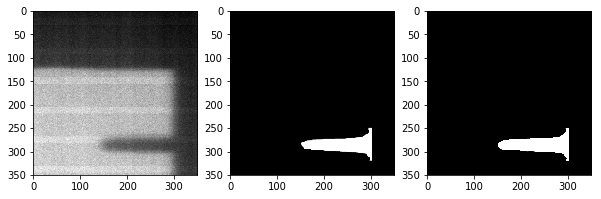

2: true_dist: 25, pred_dist: [25.030691]


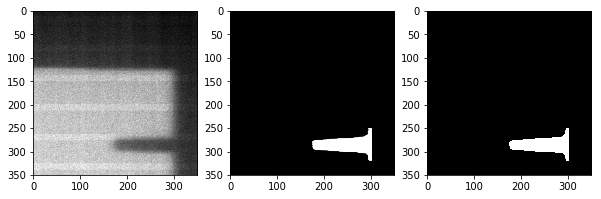

3: true_dist: 2, pred_dist: [2.0302262]


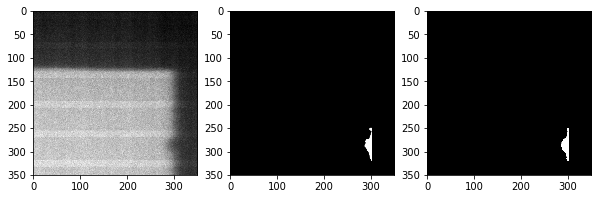

4: true_dist: 1, pred_dist: [0.98032296]


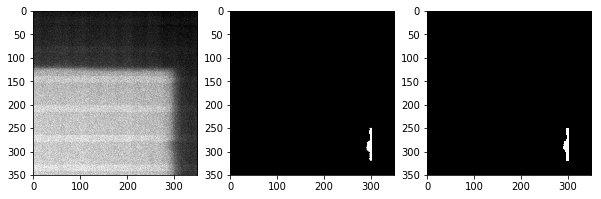

5: true_dist: 1, pred_dist: [1.0372213]


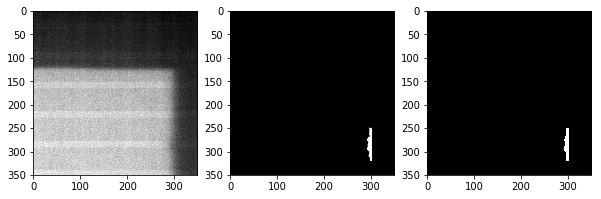

6: true_dist: 15, pred_dist: [15.02294]


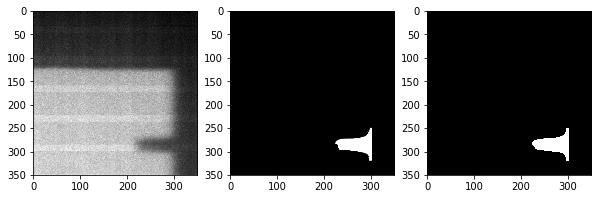

7: true_dist: 4, pred_dist: [3.9290957]


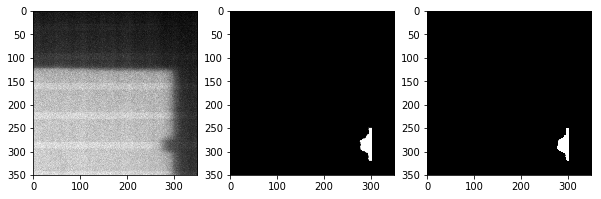

8: true_dist: 3, pred_dist: [3.0020273]


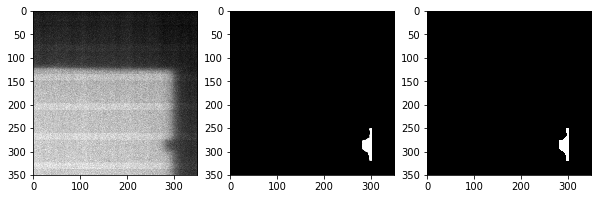

9: true_dist: 35, pred_dist: [35.06324]


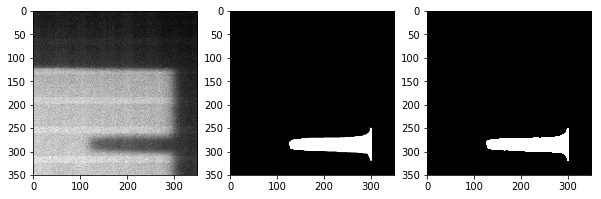

10: true_dist: 25, pred_dist: [25.011675]


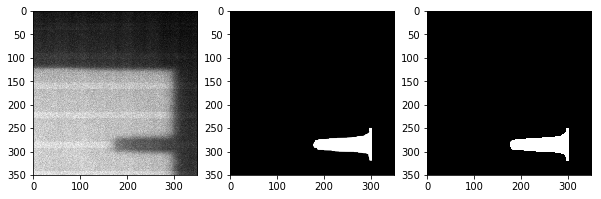

11: true_dist: 30, pred_dist: [30.037432]


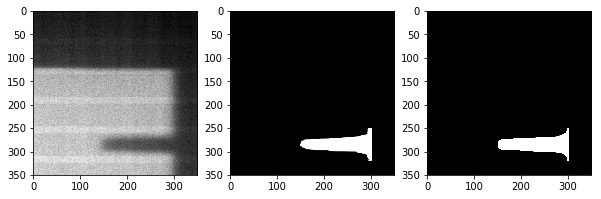

12: true_dist: 2, pred_dist: [1.9991317]


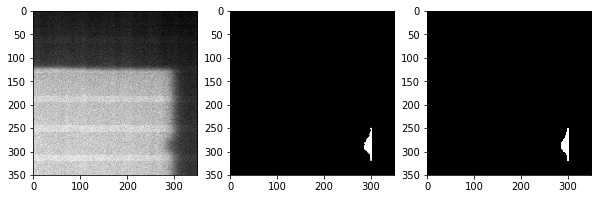

13: true_dist: 3, pred_dist: [3.0111473]


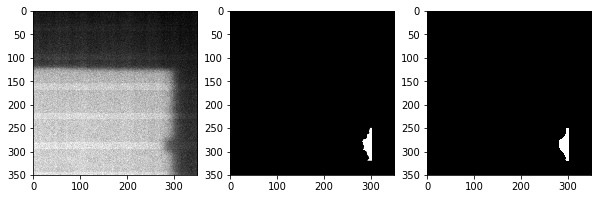

14: true_dist: 4, pred_dist: [3.9889688]


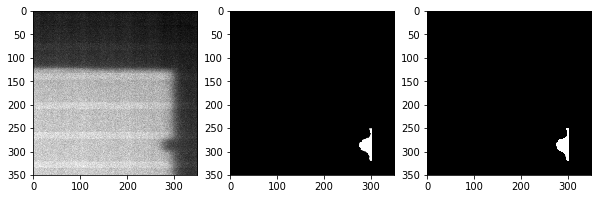

15: true_dist: 10, pred_dist: [10.040106]


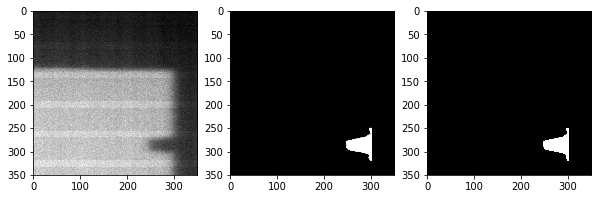

16: true_dist: 1, pred_dist: [0.9197314]


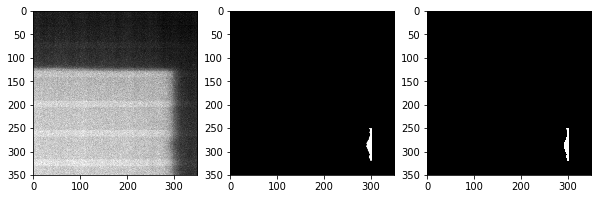

batch 2
1: true_dist: 10, pred_dist: [10.010471]


In [ ]:
for i, batch in enumerate(data_loaders['test']):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_dists = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_dist, pr_msk, pr_dist) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_dists.cpu().detach().numpy())):
    
        true_dist = tr_dist
        pred_dist = pr_dist
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [18]:
batch_size=16

In [19]:
y_true = []
y_pred = []

for i, batch in tqdm(enumerate(data_loaders['test']), total = data_lengths['test']//batch_size, desc = "Mini Batch"):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_dists = model_inference(true_images.float().to(device))
#    print("batch {}".format(i + 1))
    for j, (img, tr_dist, pr_dist) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_dists.cpu().detach().numpy())):
        true_dist = tr_dist
        pred_dist = pr_dist
        y_true.append(true_dist)
        y_pred.append(pred_dist)




In [20]:
y_pred = np.asarray(y_pred).ravel()
y_true = np.asarray(y_true)

print("mse: {}".format(mean_squared_error(y_true, y_pred)))

mse: 0.0013253064210265325


In [21]:
def get_idx(arr, key):
    return np.where(arr==key)[0]

In [22]:
def idx_mse(dist, true_arr = y_true, preds_arr = y_pred):
    idx = np.where(true_arr==dist)[0]
    mse = mean_squared_error(true_arr[idx], preds_arr[idx])
    print(dist, mse)
    return idx, mse 

In [23]:
idx_1, mse_1 = idx_mse(1)
idx_2, mse_2 = idx_mse(2)
idx_3, mse_3 = idx_mse(3)
idx_4, mse_4 = idx_mse(4)
idx_10, mse_10 = idx_mse(10)
idx_15, mse_15 = idx_mse(15)
idx_20, mse_20 = idx_mse(20)
idx_25, mse_25 = idx_mse(25)
idx_30, mse_30 = idx_mse(30)
idx_35, mse_35 = idx_mse(35)

1 0.0005974514624795862
2 0.001362218912504285
3 0.0009955838129066749
4 0.0008895397028941596
10 0.0007209069694750343
15 0.0005412863455880882
20 0.0018650946537060295
25 0.0012935535539206713
30 0.002083034847124909
35 0.0029023985174366734


In [24]:
distances = [1,2,3,4,10,15,20,25,30,35]

In [25]:
errors = [idx_mse(i)[1] for i in distances]

1 0.0005974514624795862
2 0.001362218912504285
3 0.0009955838129066749
4 0.0008895397028941596
10 0.0007209069694750343
15 0.0005412863455880882
20 0.0018650946537060295
25 0.0012935535539206713
30 0.002083034847124909
35 0.0029023985174366734


(0, 0.05)

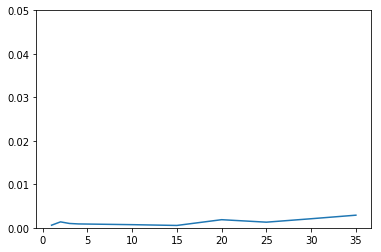

In [26]:
plt.plot(distances, errors)
plt.ylim((0,0.05))

In [27]:
np.savez_compressed("Predicted_ALL_out_model_trained_on_ALLDATA_150_epochs.npz", true=y_true, pred = y_pred)